### Denoising Autoencoders And Where To Find Them (5 points)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [5]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.transpose([0,3,1,2]).astype('float32') / 256.0

img_shape = X.shape[1:]
print("Image shape:",img_shape)

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

images not found, donwloading...
extracting...
done
Image shape: (3, 38, 38)


X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


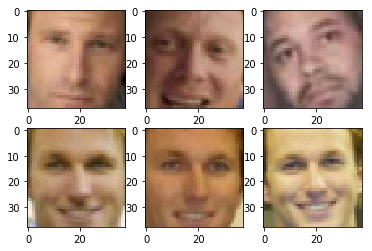

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [7]:
import theano,theano.tensor as T
import lasagne,lasagne.layers as L
def build_pca_autoencoder(img_shape,code_size=32):
    """
    Here we define a simple linear autoencoder as described above.
    We also reshape decoded data to be compatible with image shapes
    """
    inp = L.InputLayer((None,)+img_shape)
    enc = L.DenseLayer(inp,code_size,nonlinearity=None)
    
    dec = L.DenseLayer(enc,np.prod(img_shape),nonlinearity=None)  #actual decoder, height*width*3 units
    dec = L.ReshapeLayer(dec,(-1,)+img_shape)
    
    return inp,enc,dec

Meld them together into one model

In [8]:
inp, encoder, decoder = build_pca_autoencoder(img_shape,code_size=32)

code,reconstruction = L.get_output([encoder,decoder])
loss = T.mean((inp.input_var - reconstruction)**2)
updates = lasagne.updates.adamax(loss,L.get_all_params(decoder,trainable=True))

train_step = theano.function([inp.input_var],loss,updates=updates,allow_input_downcast=True)
compute_loss = theano.function([inp.input_var],loss,allow_input_downcast=True)
encode_decode = theano.function([inp.input_var],[code,reconstruction],allow_input_downcast=True)

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [9]:
from tqdm import tqdm
import sys
def iterate_minibatches(data, batch_size = 32,verbose = True):
    indices = np.random.permutation(np.arange(len(data)))
    batches = range(0, len(data), batch_size)
    if verbose: 
        batches = tqdm(batches)
    return (data[indices[start_idx:start_idx + batch_size]] for start_idx in batches)

In [31]:
for epoch in range(32):
    losses = []
    for x_batch in iterate_minibatches(X_train,batch_size=50):
        losses.append(train_step(x_batch))
    print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)
    
    val_losses = list(map(compute_loss,iterate_minibatches(X_test,verbose=False)))
    print("#%i, Test loss: %.7f"%(epoch+1,np.mean(val_losses)),flush=True)
    

100%|██████████| 237/237 [00:01<00:00, 169.00it/s]

#1, Train loss: 0.0328633


#1, Test loss: 0.0201831


100%|██████████| 237/237 [00:01<00:00, 170.85it/s]

#2, Train loss: 0.0188102


#2, Test loss: 0.0175951


100%|██████████| 237/237 [00:01<00:00, 171.34it/s]

#3, Train loss: 0.0159242


#3, Test loss: 0.0149908


100%|██████████| 237/237 [00:01<00:00, 164.78it/s]

#4, Train loss: 0.0137333
#4, Test loss: 0.0131036



100%|██████████| 237/237 [00:01<00:00, 156.70it/s]

#5, Train loss: 0.0122291


#5, Test loss: 0.0118842


100%|██████████| 237/237 [00:01<00:00, 159.53it/s]

#6, Train loss: 0.0110816
#6, Test loss: 0.0106301



100%|██████████| 237/237 [00:01<00:00, 147.94it/s]

#7, Train loss: 0.0101187


#7, Test loss: 0.0098954


100%|██████████| 237/237 [00:01<00:00, 161.09it/s]

#8, Train loss: 0.0093229
#8, Test loss: 0.0090162



100%|██████████| 237/237 [00:01<00:00, 168.29it/s]

#9, Train loss: 0.0086395


#9, Test loss: 0.0084181


100%|██████████| 237/237 [00:01<00:00, 166.60it/s]

#10, Train loss: 0.0080244


#10, Test loss: 0.0078704


100%|██████████| 237/237 [00:01<00:00, 166.45it/s]

#11, Train loss: 0.0074705


#11, Test loss: 0.0073822


100%|██████████| 237/237 [00:01<00:00, 169.54it/s]

#12, Train loss: 0.0070041


#12, Test loss: 0.0070975


100%|██████████| 237/237 [00:01<00:00, 170.07it/s]

#13, Train loss: 0.0065537


#13, Test loss: 0.0064254


100%|██████████| 237/237 [00:01<00:00, 170.18it/s]

#14, Train loss: 0.0061501


#14, Test loss: 0.0060651


100%|██████████| 237/237 [00:01<00:00, 170.58it/s]

#15, Train loss: 0.0059068
#15, Test loss: 0.0058792



100%|██████████| 237/237 [00:01<00:00, 168.27it/s]

#16, Train loss: 0.0057550


#16, Test loss: 0.0057900


100%|██████████| 237/237 [00:01<00:00, 167.70it/s]

#17, Train loss: 0.0056376


#17, Test loss: 0.0057206


100%|██████████| 237/237 [00:01<00:00, 165.83it/s]

#18, Train loss: 0.0056007


#18, Test loss: 0.0057103


100%|██████████| 237/237 [00:01<00:00, 160.82it/s]

#19, Train loss: 0.0055591
#19, Test loss: 0.0057767



100%|██████████| 237/237 [00:01<00:00, 161.20it/s]

#20, Train loss: 0.0055273
#20, Test loss: 0.0055804



100%|██████████| 237/237 [00:01<00:00, 158.03it/s]

#21, Train loss: 0.0055593
#21, Test loss: 0.0057632



100%|██████████| 237/237 [00:01<00:00, 151.59it/s]

#22, Train loss: 0.0055440
#22, Test loss: 0.0057365



100%|██████████| 237/237 [00:01<00:00, 152.79it/s]

#23, Train loss: 0.0055395
#23, Test loss: 0.0057426



100%|██████████| 237/237 [00:01<00:00, 155.75it/s]

#24, Train loss: 0.0055372


#24, Test loss: 0.0057257


100%|██████████| 237/237 [00:01<00:00, 156.84it/s]

#25, Train loss: 0.0055242


#25, Test loss: 0.0057014


100%|██████████| 237/237 [00:01<00:00, 157.94it/s]

#26, Train loss: 0.0055231


#26, Test loss: 0.0056092


100%|██████████| 237/237 [00:01<00:00, 156.25it/s]

#27, Train loss: 0.0055327


#27, Test loss: 0.0057091


100%|██████████| 237/237 [00:01<00:00, 156.53it/s]

#28, Train loss: 0.0055308


#28, Test loss: 0.0055984


100%|██████████| 237/237 [00:01<00:00, 157.31it/s]

#29, Train loss: 0.0055105


#29, Test loss: 0.0056530


100%|██████████| 237/237 [00:01<00:00, 157.56it/s]

#30, Train loss: 0.0055134


#30, Test loss: 0.0057279


100%|██████████| 237/237 [00:01<00:00, 156.72it/s]

#31, Train loss: 0.0055160


#31, Test loss: 0.0059535


100%|██████████| 237/237 [00:01<00:00, 158.37it/s]

#32, Train loss: 0.0055138
#32, Test loss: 0.0055631


In [10]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code,reco = encode_decode(img[None])

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.transpose([1,2,0]))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].transpose([1,2,0]).clip(0,1))
    plt.show()


Final MSE: 0.00558995996806


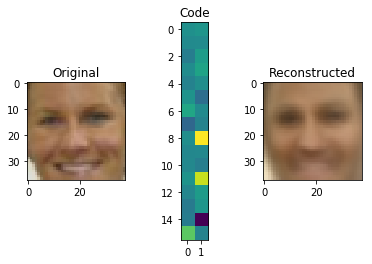

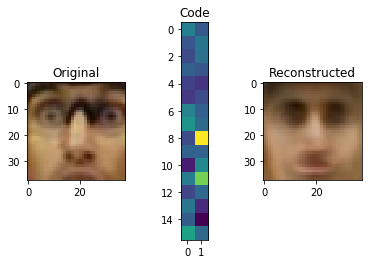

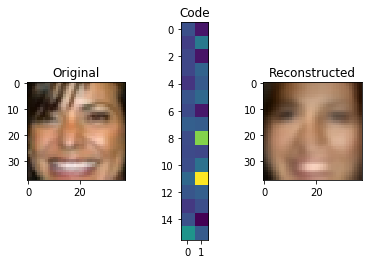

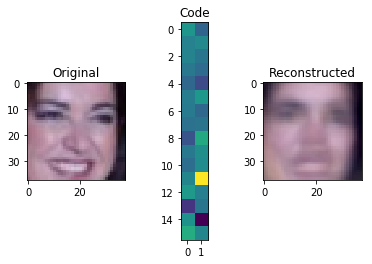

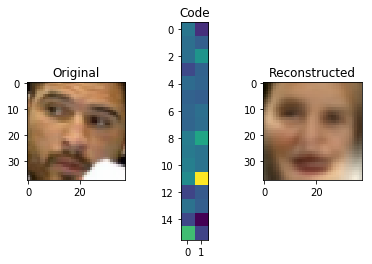

In [32]:
score = np.mean(list(map(compute_loss,iterate_minibatches(X_test,verbose=False))))
print("Final MSE:",score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [38]:
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    C,H,W = img_shape
    
    inp = L.InputLayer((None,)+img_shape)
    
    #enc_Conv_1 = L.Conv2DLayer(inp, num_filters = 16, filter_size = (2, 2),
    ##                           nonlinearity = None)
    
    #enc_Pool = L.Pool2DLayer(enc_Conv_1, pool_size = 3)
    
    #enc_Conv_2 = L.Conv2DLayer(enc_Pool, num_filters = 16, filter_size = (3, 3),
    #                           nonlinearity = None)
    
    enc_layer_1 = L.DenseLayer(inp, code_size * 16, nonlinearity=lasagne.nonlinearities.rectify)
    
    enc_norm_1 = L.BatchNormLayer(enc_layer_1)
    
    enc_layer_2 = L.DenseLayer(enc_norm_1, code_size * 8, nonlinearity = lasagne.nonlinearities.sigmoid)
    
    enc_norm_2 = L.BatchNormLayer(enc_layer_2)
    
    enc_layer_3 = L.DenseLayer(enc_norm_2, code_size * 4, nonlinearity= lasagne.nonlinearities.selu)
    
    enc_norm_3 = L.BatchNormLayer(enc_layer_3)
    
    enc_layer_4 = L.DenseLayer(enc_norm_3, code_size * 2, nonlinearity= lasagne.nonlinearities.elu)
    
    enc_norm_4 = L.BatchNormLayer(enc_layer_4)
    
    encoder = L.DenseLayer(enc_norm_4, code_size, nonlinearity=None)
    
    dec_layer_1 = L.NonlinearityLayer(encoder, nonlinearity=lasagne.nonlinearities.elu)
    
    dec_norm_1 = L.BatchNormLayer(dec_layer_1)
    
    dec_layer_2 = L.DenseLayer(dec_norm_1, code_size * 2, nonlinearity=lasagne.nonlinearities.elu)  #actual decoder, height*width*3 units
    
    dec_norm_2 = L.BatchNormLayer(dec_layer_2)
    
    dec_layer_3 = L.DenseLayer(dec_norm_2, code_size * 4, nonlinearity = lasagne.nonlinearities.selu)
    
    dec_norm_3 = L.BatchNormLayer(dec_layer_3)
    
    dec_layer_4 = L.DenseLayer(dec_norm_3, code_size * 8, nonlinearity=lasagne.nonlinearities.elu)  #actual decoder, height*width*3 units
    
    dec_norm_4 = L.BatchNormLayer(dec_layer_4)
    
    dec_layer_5 = L.DenseLayer(dec_norm_4, code_size * 16, nonlinearity = lasagne.nonlinearities.selu)
    
    dec_norm_5 = L.BatchNormLayer(dec_layer_5)
    
    decoder = L.DenseLayer(dec_norm_5, np.prod(img_shape), nonlinearity=lasagne.nonlinearities.elu)
    decoder = L.ReshapeLayer(decoder,(-1,)+img_shape)
    
    
    return inp,encoder,decoder

In [39]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    _,encoder,decoder = build_deep_autoencoder(img_shape,code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==img_shape,   "decoder must output an image of valid shape"
    assert len(L.get_all_params(decoder))>=6,       "encoder must contain at least 3 dense layers"
    
    for layer in L.get_all_layers(decoder):
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [40]:
inp, encoder, decoder = build_pca_autoencoder(img_shape,code_size=32)

code,reconstruction = L.get_output([encoder,decoder])
loss = T.mean((inp.input_var - reconstruction)**2)
updates = lasagne.updates.adamax(loss,L.get_all_params(decoder,trainable=True))

train_step = theano.function([inp.input_var],loss,updates=updates,allow_input_downcast=True)
compute_loss = theano.function([inp.input_var],loss,allow_input_downcast=True)
encode_decode = theano.function([inp.input_var],[code,reconstruction],allow_input_downcast=True)

Training may take long, it's okay.

In [41]:
for epoch in range(32):
    losses = []
    for x_batch in iterate_minibatches(X_train,batch_size=50):
        losses.append(train_step(x_batch))
    print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)
    
    val_losses = list(map(compute_loss,iterate_minibatches(X_test,verbose=False)))
    print("#%i, Test loss: %.7f"%(epoch+1,np.mean(val_losses)),flush=True)
    

100%|██████████| 237/237 [00:01<00:00, 156.08it/s]

#1, Train loss: 0.0329142


#1, Test loss: 0.0207180


100%|██████████| 237/237 [00:01<00:00, 169.47it/s]

#2, Train loss: 0.0192658


#2, Test loss: 0.0179481


100%|██████████| 237/237 [00:01<00:00, 174.42it/s]

#3, Train loss: 0.0161578
#3, Test loss: 0.0149783



100%|██████████| 237/237 [00:01<00:00, 175.01it/s]

#4, Train loss: 0.0138174
#4, Test loss: 0.0130710



100%|██████████| 237/237 [00:01<00:00, 167.65it/s]

#5, Train loss: 0.0123008


#5, Test loss: 0.0119677


100%|██████████| 237/237 [00:01<00:00, 165.99it/s]

#6, Train loss: 0.0112206


#6, Test loss: 0.0110520


100%|██████████| 237/237 [00:01<00:00, 167.25it/s]

#7, Train loss: 0.0103245


#7, Test loss: 0.0100348


100%|██████████| 237/237 [00:01<00:00, 166.59it/s]

#8, Train loss: 0.0094730


#8, Test loss: 0.0094024


100%|██████████| 237/237 [00:01<00:00, 166.07it/s]

#9, Train loss: 0.0087368


#9, Test loss: 0.0085422


100%|██████████| 237/237 [00:01<00:00, 166.53it/s]

#10, Train loss: 0.0080872


#10, Test loss: 0.0079580


100%|██████████| 237/237 [00:01<00:00, 167.95it/s]

#11, Train loss: 0.0074667


#11, Test loss: 0.0073196


100%|██████████| 237/237 [00:01<00:00, 167.28it/s]

#12, Train loss: 0.0069489


#12, Test loss: 0.0069367


100%|██████████| 237/237 [00:01<00:00, 169.13it/s]

#13, Train loss: 0.0064782


#13, Test loss: 0.0063526


100%|██████████| 237/237 [00:01<00:00, 166.32it/s]

#14, Train loss: 0.0061165


#14, Test loss: 0.0060414


100%|██████████| 237/237 [00:01<00:00, 174.15it/s]

#15, Train loss: 0.0059080
#15, Test loss: 0.0059758



100%|██████████| 237/237 [00:01<00:00, 169.50it/s]

#16, Train loss: 0.0057565
#16, Test loss: 0.0057566



100%|██████████| 237/237 [00:01<00:00, 172.04it/s]

#17, Train loss: 0.0056223
#17, Test loss: 0.0056973



100%|██████████| 237/237 [00:01<00:00, 173.44it/s]

#18, Train loss: 0.0055938
#18, Test loss: 0.0057436



100%|██████████| 237/237 [00:01<00:00, 153.81it/s]

#19, Train loss: 0.0055786


#19, Test loss: 0.0056808


100%|██████████| 237/237 [00:01<00:00, 165.59it/s]

#20, Train loss: 0.0055558


#20, Test loss: 0.0056004


100%|██████████| 237/237 [00:01<00:00, 165.98it/s]

#21, Train loss: 0.0055570


#21, Test loss: 0.0056707


100%|██████████| 237/237 [00:01<00:00, 158.39it/s]

#22, Train loss: 0.0055504
#22, Test loss: 0.0056855



100%|██████████| 237/237 [00:01<00:00, 164.61it/s]

#23, Train loss: 0.0055489


#23, Test loss: 0.0056345


100%|██████████| 237/237 [00:01<00:00, 169.11it/s]

#24, Train loss: 0.0055410


#24, Test loss: 0.0056427


100%|██████████| 237/237 [00:01<00:00, 171.18it/s]

#25, Train loss: 0.0055466
#25, Test loss: 0.0055973



100%|██████████| 237/237 [00:01<00:00, 163.02it/s]

#26, Train loss: 0.0055269
#26, Test loss: 0.0056318



100%|██████████| 237/237 [00:01<00:00, 164.17it/s]

#27, Train loss: 0.0055312
#27, Test loss: 0.0055629



100%|██████████| 237/237 [00:01<00:00, 163.16it/s]

#28, Train loss: 0.0055368
#28, Test loss: 0.0056418



100%|██████████| 237/237 [00:01<00:00, 165.65it/s]

#29, Train loss: 0.0055192


#29, Test loss: 0.0056165


100%|██████████| 237/237 [00:01<00:00, 168.03it/s]

#30, Train loss: 0.0055044


#30, Test loss: 0.0055906


100%|██████████| 237/237 [00:01<00:00, 164.23it/s]

#31, Train loss: 0.0055247
#31, Test loss: 0.0057102



100%|██████████| 237/237 [00:01<00:00, 165.97it/s]

#32, Train loss: 0.0055328


#32, Test loss: 0.0055380


In [42]:
reconstruction_mse = np.mean(list(map(compute_loss,iterate_minibatches(X_test,verbose=False))))
assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
assert len(encoder.output_shape)==2 and encoder.output_shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

AssertionError: Compression is too lossy. See tips below.

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [43]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    noise = np.random.normal(scale = sigma, size = X.shape)
        
    return X + noise
    

In [44]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

In [45]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0].transpose([1,2,0]))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0].transpose([1,2,0]))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0].transpose([1,2,0]))

ValueError: Floating point image RGB values must be in the 0..1 range.

In [46]:
inp, encoder, decoder = build_pca_autoencoder(img_shape,code_size=32)

code,reconstruction = L.get_output([encoder,decoder])
loss = T.mean((inp.input_var - reconstruction)**2)
updates = lasagne.updates.adamax(loss,L.get_all_params(decoder,trainable=True))

train_step = theano.function([inp.input_var],loss,updates=updates,allow_input_downcast=True)
compute_loss = theano.function([inp.input_var],loss,allow_input_downcast=True)
encode_decode = theano.function([inp.input_var],[code,reconstruction],allow_input_downcast=True)

In [47]:
for epoch in range(50):
    print("Epoch %i/50, Generating corrupted samples..."%epoch)
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    losses = []
    for x_batch in iterate_minibatches(X_train_noise,batch_size=50):
        losses.append(train_step(x_batch))
    print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)
    
    val_losses = list(map(compute_loss,iterate_minibatches(X_test_noise,verbose=False)))
    print("#%i, Test loss: %.7f"%(epoch+1,np.mean(val_losses)),flush=True)


Epoch 0/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 132.81it/s]

#1, Train loss: 0.0427092
#1, Test loss: 0.0306212


Epoch 1/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 155.07it/s]

#2, Train loss: 0.0293556


#2, Test loss: 0.0279946
Epoch 2/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 155.28it/s]

#3, Train loss: 0.0261860


#3, Test loss: 0.0250303
Epoch 3/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 156.37it/s]

#4, Train loss: 0.0238920


#4, Test loss: 0.0232623
Epoch 4/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 150.13it/s]

#5, Train loss: 0.0223869
#5, Test loss: 0.0220243


Epoch 5/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 147.96it/s]

#6, Train loss: 0.0212837
#6, Test loss: 0.0210374


Epoch 6/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 152.73it/s]

#7, Train loss: 0.0203199
#7, Test loss: 0.0202165


Epoch 7/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 159.36it/s]

#8, Train loss: 0.0194593


#8, Test loss: 0.0191621
Epoch 8/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 157.81it/s]

#9, Train loss: 0.0187448


#9, Test loss: 0.0185851
Epoch 9/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 157.04it/s]

#10, Train loss: 0.0181282


#10, Test loss: 0.0179600
Epoch 10/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 156.38it/s]

#11, Train loss: 0.0175992


#11, Test loss: 0.0174947
Epoch 11/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 153.68it/s]

#12, Train loss: 0.0170406
#12, Test loss: 0.0169104


Epoch 12/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 158.71it/s]

#13, Train loss: 0.0166009


#13, Test loss: 0.0166809
Epoch 13/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 159.30it/s]

#14, Train loss: 0.0162883


#14, Test loss: 0.0161778
Epoch 14/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 152.31it/s]

#15, Train loss: 0.0160304
#15, Test loss: 0.0161517


Epoch 15/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 155.65it/s]

#16, Train loss: 0.0159164


#16, Test loss: 0.0159683
Epoch 16/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 158.15it/s]

#17, Train loss: 0.0158581


#17, Test loss: 0.0159026
Epoch 17/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 155.46it/s]

#18, Train loss: 0.0158170


#18, Test loss: 0.0163016
Epoch 18/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 154.52it/s]

#19, Train loss: 0.0157678


#19, Test loss: 0.0159233
Epoch 19/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 158.21it/s]

#20, Train loss: 0.0157767


#20, Test loss: 0.0159518
Epoch 20/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 152.39it/s]

#21, Train loss: 0.0157281
#21, Test loss: 0.0158169


Epoch 21/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 142.23it/s]

#22, Train loss: 0.0157606
#22, Test loss: 0.0158034


Epoch 22/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 151.85it/s]

#23, Train loss: 0.0156749
#23, Test loss: 0.0157488


Epoch 23/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 149.97it/s]

#24, Train loss: 0.0157194
#24, Test loss: 0.0158004


Epoch 24/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 148.09it/s]

#25, Train loss: 0.0156773
#25, Test loss: 0.0157715


Epoch 25/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 149.28it/s]

#26, Train loss: 0.0156789
#26, Test loss: 0.0162033


Epoch 26/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 134.62it/s]

#27, Train loss: 0.0156559


#27, Test loss: 0.0157335
Epoch 27/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 144.75it/s]

#28, Train loss: 0.0156855


#28, Test loss: 0.0157529
Epoch 28/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 148.25it/s]

#29, Train loss: 0.0156366
#29, Test loss: 0.0157863


Epoch 29/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 147.91it/s]

#30, Train loss: 0.0156348
#30, Test loss: 0.0159647


Epoch 30/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 148.93it/s]

#31, Train loss: 0.0156493
#31, Test loss: 0.0157123


Epoch 31/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 155.99it/s]

#32, Train loss: 0.0156021


#32, Test loss: 0.0157243
Epoch 32/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 157.21it/s]

#33, Train loss: 0.0156145


#33, Test loss: 0.0157582
Epoch 33/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 140.44it/s]

#34, Train loss: 0.0155827
#34, Test loss: 0.0157199


Epoch 34/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 154.79it/s]

#35, Train loss: 0.0156030


#35, Test loss: 0.0156416
Epoch 35/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 156.32it/s]

#36, Train loss: 0.0155883


#36, Test loss: 0.0156966
Epoch 36/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 156.19it/s]

#37, Train loss: 0.0155783


#37, Test loss: 0.0157455
Epoch 37/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 157.96it/s]

#38, Train loss: 0.0155801


#38, Test loss: 0.0157335
Epoch 38/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 156.60it/s]

#39, Train loss: 0.0155690


#39, Test loss: 0.0156246
Epoch 39/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 158.72it/s]

#40, Train loss: 0.0155454


#40, Test loss: 0.0156283
Epoch 40/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 158.21it/s]

#41, Train loss: 0.0155656


#41, Test loss: 0.0156173
Epoch 41/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 158.61it/s]

#42, Train loss: 0.0155470


#42, Test loss: 0.0157651
Epoch 42/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 158.28it/s]

#43, Train loss: 0.0155664


#43, Test loss: 0.0156423
Epoch 43/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 158.24it/s]

#44, Train loss: 0.0155694


#44, Test loss: 0.0157155
Epoch 44/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 158.72it/s]

#45, Train loss: 0.0155582


#45, Test loss: 0.0156519
Epoch 45/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 158.18it/s]

#46, Train loss: 0.0155804


#46, Test loss: 0.0157475
Epoch 46/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 158.68it/s]

#47, Train loss: 0.0155130


#47, Test loss: 0.0156465
Epoch 47/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 157.22it/s]

#48, Train loss: 0.0155516


#48, Test loss: 0.0156554
Epoch 48/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 154.24it/s]

#49, Train loss: 0.0155407


#49, Test loss: 0.0157834
Epoch 49/50, Generating corrupted samples...


100%|██████████| 237/237 [00:01<00:00, 156.77it/s]

#50, Train loss: 0.0155411


#50, Test loss: 0.0156571


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.00570110470965


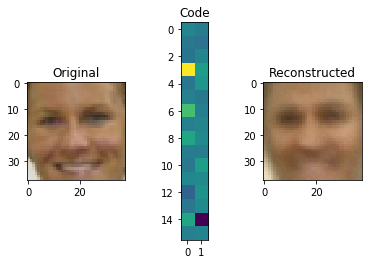

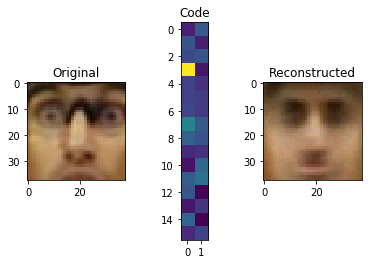

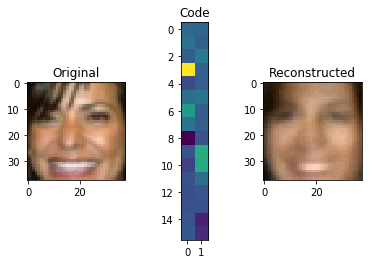

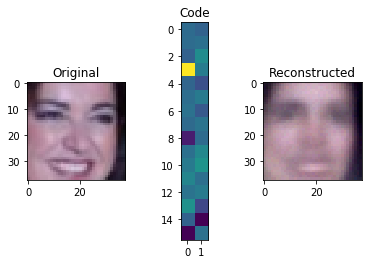

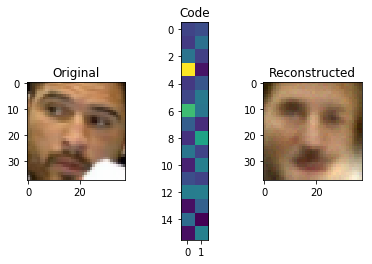

In [48]:
reconstruction_mse = np.mean(list(map(compute_loss,iterate_minibatches(X_test,verbose=False))))
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [49]:
#compile function that encodes batch of images into a batch of vector[batch,code_size]
encode = theano.function([inp.input_var],code,allow_input_downcast=True)
#... and another function that casts those codes back into images
codes = T.matrix("codes")
decode = theano.function([codes],L.get_output(decoder,{encoder:codes}))


In [50]:
images = X_train
codes = encode_decode(images)[0]
assert len(codes) == len(images)

In [51]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

/Users/s.latatye/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/approximate.py:220: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [52]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encode_decode(image[None])[0]
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [53]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

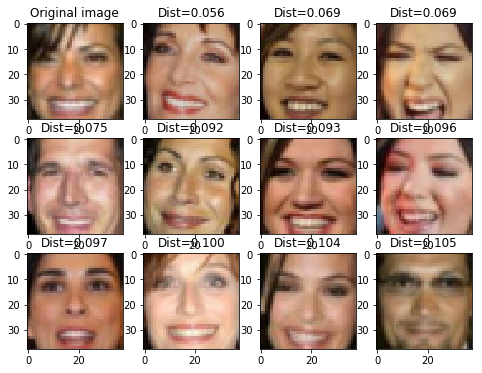

In [54]:
#smiles
show_similar(X_test[2])

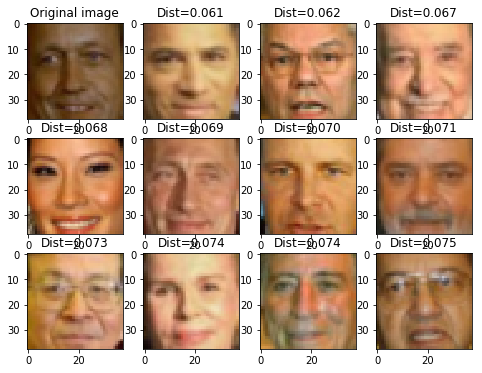

In [55]:
#ethnicity
show_similar(X_test[500])

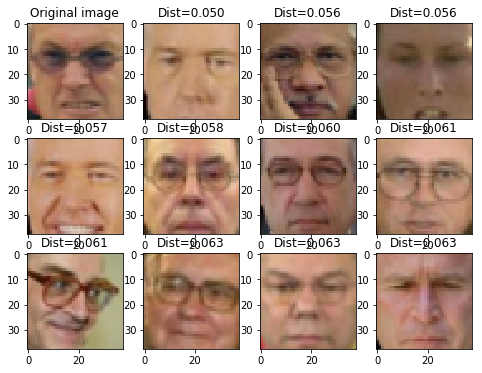

In [56]:
#glasses
show_similar(X_test[66])

## Bonus: cheap image morphing


In [59]:
!wget https://pp.userapi.com/c841232/v841232973/10f7d/6VeWmm_fA2E.jpg svet.jpg

--2017-11-17 21:38:18--  https://pp.userapi.com/c841232/v841232973/10f7d/6VeWmm_fA2E.jpg
Resolving pp.userapi.com... 87.240.182.234, 87.240.182.232, 93.186.238.48, ...
Connecting to pp.userapi.com|87.240.182.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 647668 (632K) [image/jpeg]
Saving to: '6VeWmm_fA2E.jpg'

6VeWmm_fA2E.jpg     100%[===================>] 632.49K  --.-KB/s    in 0.08s   

2017-11-17 21:38:19 (8.05 MB/s) - '6VeWmm_fA2E.jpg' saved [647668/647668]

--2017-11-17 21:38:19--  http://svet.jpg/
Resolving svet.jpg... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address 'svet.jpg'
FINISHED --2017-11-17 21:38:19--
Total wall clock time: 0.2s
Downloaded: 1 files, 632K in 0.08s (8.05 MB/s)


In [82]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = img[:, :, :: -1]
    
    img = img - MEAN_VALUES[None, None, :]
    
    #convert from [w,h,3 to 1,3,w,h]
    img = np.transpose(img, (2, 0, 1))[None]
    return img.astype('float32')

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

/Users/s.latatye/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/s.latatye/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


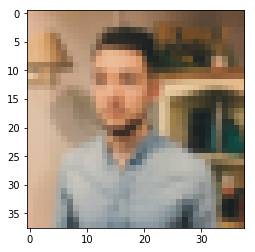

In [89]:
from scipy.misc import imread, imsave, imresize
image2 = imread('./serg.jpg')
image2 = imresize(image2, (38, 38))
plt.imshow(image2)
plt.show()

In [86]:
X[0].shape, image1.shape

((3, 38, 38), (224, 224, 3))

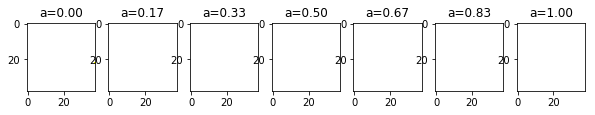

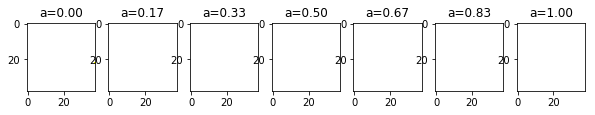

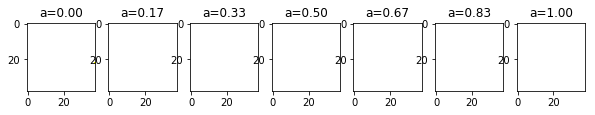

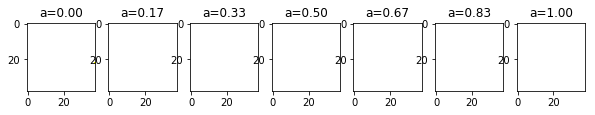

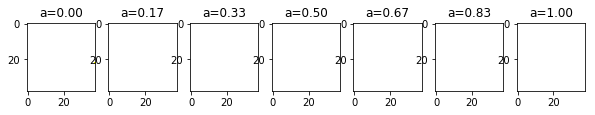

In [90]:

for _ in range(5):
    #image1,image2 = preprocess(image1), preprocess(image2)

    code1, code2 = encode(np.stack([image1.transpose([2, 0, 1]),image2.transpose([2, 0, 1])]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decode(output_code[None])[0]

        plt.subplot(1,7,i+1)
        plt.imshow(output_image.transpose([1,2,0]).clip(0,1))
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.